In [1]:
from IPython.core.display import HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%load_ext autoreload
%autoreload 1

Author: Andrew Tarzia

Date Created: 05 Aug 2018

Distributed under the terms of the MIT License.

# Notebook to analyse all enzymes used in ZIF-8 experiments using BRENDA database

TODO:
- add license
- modifications
    - introduce exposure consideration
        - get another method for calculating exposure without structure?
    - generalise code to multiple target residues ("targ = convert_to_one_letter_code_sing('target_res')" needs to act on a list

In [2]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.Alphabet import IUPAC
from rdkit.Chem.Draw import IPythonConsole  # to show molecules in notebook
import time
import numpy as np
import pandas as pd
# ensure cpickle usage
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.Descriptors3D import NPR1, NPR2, PMI1, PMI2, PMI3
from rdkit.Chem.Draw.MolDrawing import MolDrawing
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit.Geometry import rdGeometry
from rdkit.Chem import PyMol
from rdkit import Geometry
import tempfile
%aimport pi_fn
%aimport parameters
%aimport brenda_IO
%aimport SABIO_IO
%aimport rdkit_functions
%aimport ellipsoid
%aimport DB_functions
%aimport CHEBI_IO
%aimport BKMS_IO
%aimport KEGG_IO
%aimport Uniprot_IO
%aimport rxn_syst

# Calculate pI of all sequences in EC No. used in literature
## Produces distribution for each EC No.

## Notes:
### Biopython:
- pK values and the methods are taken from::
    * Bjellqvist, B.,Hughes, G.J., Pasquali, Ch., Paquet, N., Ravier, F.,
    Sanchez, J.-Ch., Frutiger, S. & Hochstrasser, D.F.
    The focusing positions of polypeptides in immobilized pH gradients can be
    predicted from their amino acid sequences. Electrophoresis 1993, 14,
    1023-1031.
    * Bjellqvist, B., Basse, B., Olsen, E. and Celis, J.E.
    Reference points for comparisons of two-dimensional maps of proteins from
    different human cell types defined in a pH scale where isoelectric points
    correlate with polypeptide compositions. Electrophoresis 1994, 15, 529-539.

|  AA | pKa  |
|-----|------|
| ASP | 4.05 |
| GLU | 4.45 |
| HIS | 5.98 |
| CYS | 9.00 |
| TYR | 10.0 |
| LYS | 10.0 |
| ARG | 12.0 |
| N-terminus | 7.50 |
| N-terminus : GLU | 7.7 |
| N-terminus : VAL | 7.44 |
| N-terminus : THR | 6.82 |
| N-terminus : PRO | 8.36 |
| N-terminus : SER | 6.93 |
| N-terminus : MET | 7.00 |
| N-terminus : ALA | 7.59 |
| C-terminus | 3.55 |
| C-terminus : ASP | 4.55 |
| C-terminus : GLU | 4.75 |

- with the above pKas and the data set in Tash's paper (DOI:) we apply a pI cut off = XX.


### Modified pIs:
- assuming sequence only and therefore cannot use DSSP to calculate exposure

In [3]:
# get parameters
param_dict = parameters.get_parameters()

# input parameters
database_directory = '/home/atarzia/psp/sequence_db/bio_min_dataset/'
output_dir = database_directory

In [4]:
# set EC numbers of interest based on dataset
# 'none' in species lists implies species was not given with literature report.
EC_set = {
    # EC : species list
    '1.11.1.5': ['equus caballus', ],
    '1.11.1.6': ['bos taurus', ],
    '1.11.1.7': ['armoracia rusticana', ],
    '1.9.3.1': ['equus caballus', ],
    '1.1.5.2': ['none', ],
    '3.5.1.5': ['canavalia ensiformis'],
    '1.1.3.4': ['aspergillus niger'],
    '1.13.12.4': ['none'],
    '3.2.1.26': ['none'],
    '3.1.1.3': ['thermomyces lanuginosus', 'alcaligenes sp.',
                'pseudomonas fluorescens',
                'rhizomucor miehei', 'candida antarctica',
                'aspergillus niger'],
    '3.1.1.6': ['lactobacillus acidophilus'],
    '3.5.1.11': ['none'],
    }

In [5]:
# get input FASTA file names
database_names = []
for i in glob.glob(database_directory+"*fasta"):
    if "_mod" not in i:
        database_names.append(i)
database_names = sorted(database_names)
print('databases:')
for i in database_names:
    print('--', i.replace(database_directory, ''))

# prepare output CSV file
redo_pi = input('redo pI calculation (True = yes, False = no)')
if redo_pi == 'True':
    redo_pi = True
    pi_fn.prepare_out_csv(output_dir, param_dict)
    # fix formatting of FASTA files to match BIOPYTHON readable
    pi_fn.fix_fasta(database_names)

databases:
-- 1_11_1_5__BRENDA_sequences.fasta
-- 1_11_1_6__BRENDA_sequences.fasta
-- 1_11_1_7__BRENDA_sequences.fasta
-- 1_13_12_4__BRENDA_sequences.fasta
-- 1_1_3_4__BRENDA_sequences.fasta
-- 1_1_5_2__BRENDA_sequences.fasta
-- 1_9_3_1__BRENDA_sequences.fasta
-- 3_1_1_3__BRENDA_sequences.fasta
-- 3_1_1_6__BRENDA_sequences.fasta
-- 3_2_1_26__BRENDA_sequences.fasta
-- 3_5_1_11__BRENDA_sequences.fasta
-- 3_5_1_5__BRENDA_sequences.fasta
redo pI calculation (True = yes, False = no)False


calculate all pIs for target EC sequences
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_5__BRENDA_sequences.fasta
--- finished 2220 sequences in 0.69 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_6__BRENDA_sequences.fasta
--- finished 22068 sequences in 7.67 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_7__BRENDA_sequences.fasta
--- finished 16288 sequences in 4.23 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_13_12_4__BRENDA_sequences.fasta
--- finished 379 sequences in 0.12 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_1_3_4__BRENDA_sequences.fasta
--- finished 36 sequences in 0.02 seconds ---
plot distribution of pIs
done
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_1_5_2__BRENDA_sequences.fasta
--- finished 1765 sequences in 0.67 seconds ---
plot d

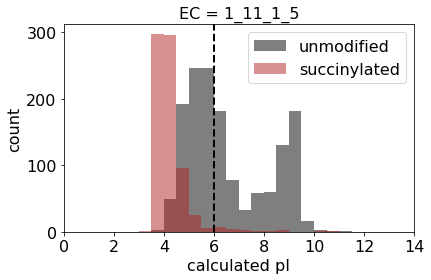

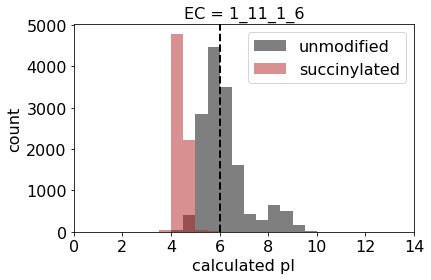

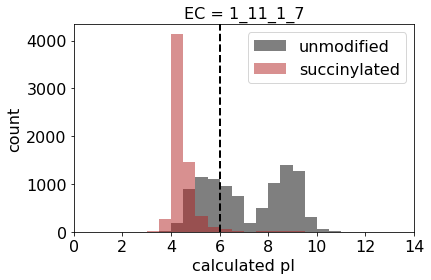

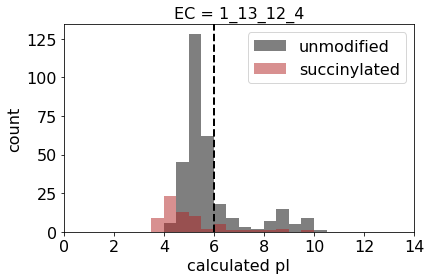

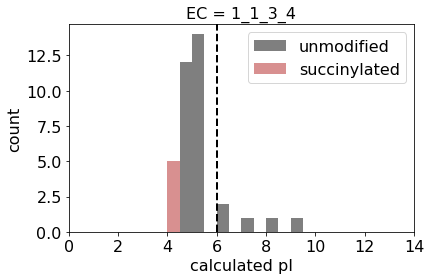

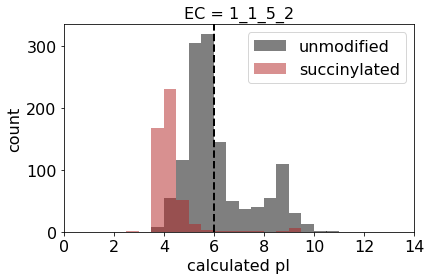

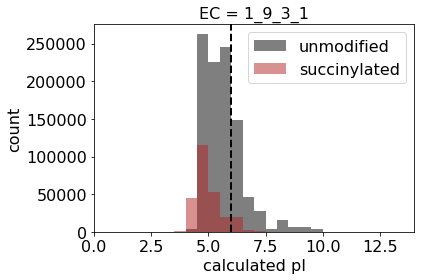

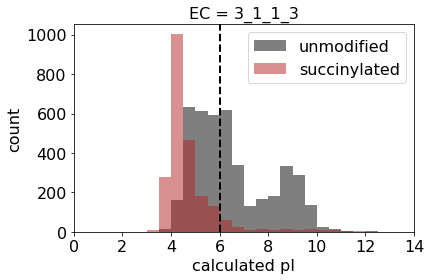

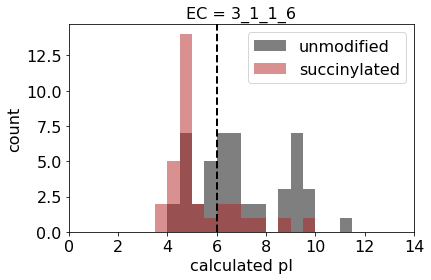

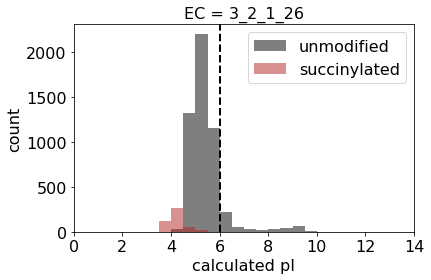

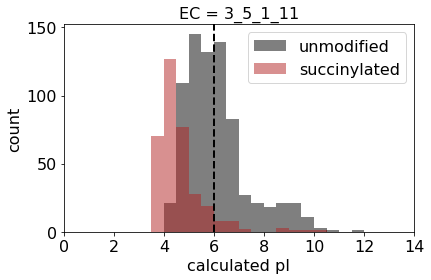

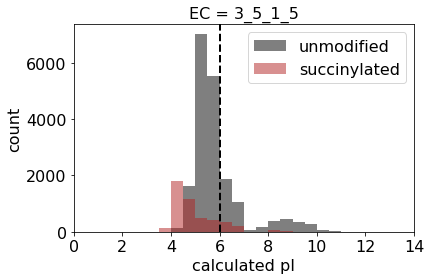

In [9]:
print('calculate all pIs for target EC sequences')
for EC_file in database_names:
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    print('doing:', EC_file)
    file_mod = EC_file.replace(".fasta", "_mod.fasta")
    if redo_pi is True:
        pi_fn.calculate_pI_from_file(file_mod, param_dict, output_dir)
    print('plot distribution of pIs')
    pi_data = pd.read_csv(output_dir+param_dict['out_CSV_pi'], index_col=False)
    EC_pi_data = pi_data[pi_data['fasta_file'] == file_mod]
    pi_fn.plot_EC_pI_dist(EC_pi_data, param_dict,
                          filename=file_mod.replace('.fasta', '.pdf'),
                          title=file_mod.replace(output_dir, '').replace('__BRENDA_sequences_mod.fasta', ''))
    print('done')

(0, 30000)

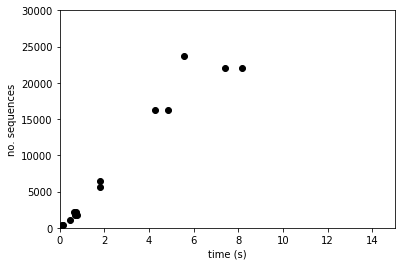

In [10]:
times = [0.74, 8.18, 4.85, 0.13, 0.02, 0.78, 
         0.62, 7.42, 4.26, 0.11, 0.01, 0.67, 
         300.89, 1.81, 0.03, 1.82, 0.44, 5.56]
seqs = [2220, 22068, 16288, 379, 36, 1765, 2220,
        22068, 16288, 379, 36, 1765, 1253592,
        6487, 80, 5665, 1098, 23660]
plt.scatter(times, seqs, c='k')
plt.xlabel('time (s)')
plt.ylabel('no. sequences')
plt.xlim(0, 15)
plt.ylim(0, 30000)

# Collect pI of species used in Literature data base using BRENDA

In [11]:
# get parameters
param_dict = parameters.get_parameters()

# input parameters
database_directory = '/home/atarzia/psp/sequence_db/bio_min_dataset/'
output_dir = database_directory

In [12]:
# set EC numbers of interest based on dataset
# 'none' in species lists implies species was not given with literature report.
EC_set = {
    # EC : species list
    '1.11.1.5': ['equus caballus', ],
    '1.11.1.6': ['bos taurus', ],
    '1.11.1.7': ['armoracia rusticana', ],
    '1.9.3.1': ['equus caballus', ],
    '1.1.5.2': ['none', ],
    '3.5.1.5': ['canavalia ensiformis'],
    '1.1.3.4': ['aspergillus niger'],
    '1.13.12.4': ['none'],
    '3.2.1.26': ['none'],
    '3.1.1.3': ['thermomyces lanuginosus', 'alcaligenes sp.',
                'pseudomonas fluorescens',
                'rhizomucor miehei', 'candida antarctica',
                'aspergillus niger'],
    '3.1.1.6': ['lactobacillus acidophilus'],
    '3.5.1.11': ['none'],
    }

In [13]:
# read in pI output file
pi_data = pd.read_csv(output_dir+param_dict['out_CSV_pi'], index_col=False)

In [14]:
print('Screen all Enzymes in EC Classes using BRENDA data')
count_done = 0
total_start_time = time.time()
for EC_file in database_names:
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    print('-----------------------------------------------')
    print('doing:', EC_file)
    file_mod = EC_file.replace(".fasta", "_mod.fasta")
    EC_pi_data = pi_data[pi_data['fasta_file'] == file_mod]
    # only keep those that pass the pI test
    pi_passed_data = EC_pi_data[EC_pi_data['pi'] < param_dict['cutoff_pi']]
    print('--- ', 
          len(pi_passed_data), 'proteins out of', len(EC_pi_data), 
          'remain, OR', int(len(pi_passed_data)/len(EC_pi_data)*100),
          "% ---")
    EC_no = list(set(EC_pi_data['EC.code']))[0].replace(' ', '').replace(".", "_")
    print('EC:', EC_no.replace("_", "."))
    br_datafile = 'brenda_download_'+EC_no+'.txt'
    # convert br_datafile into dictionary
    br_symbols, br_data = brenda_IO.get_brenda_dict(param_dict['BRENDA_DB_loc']+br_datafile)
    # from here is quite bio-min assay literature specific - although the code can be reused
    # get species of interest from known EC records
    species_of_interest = EC_set[EC_no.replace('_', '.')]
    for spec in species_of_interest:
        print('species:', spec)
        # is species in sequence data?
        spec_in_seq, spec_in_br = brenda_IO.is_species_reported(spec, 
                                                                EC_pi_data, 
                                                                br_data, 
                                                                verbose=True)
        PR_of_int = []
        for i in sorted(br_data['PR']):
            if spec in i.lower():
                # this assumes that the first item of each line is always "#"
                PR_info = i.split("#")[1]            
                if PR_info not in PR_of_int:
                    PR_of_int.append(PR_info)
        # get pI from BRENDA
        prop_of_int = 'PI'
        list_of_int = br_data[prop_of_int]
        # get list of protein codes with property of interest
        EC_prop_PR_codes = brenda_IO.get_prop_PR_codes(list_of_int)
        value_of_int = {}
        for PR in PR_of_int:
            if PR in set([j for i in EC_prop_PR_codes.values() for j in i ]):
                print('protein code:', PR, 'has', prop_of_int, 'in BRENDA')
            else:
                print('protein code:', PR, 'does not have', prop_of_int, 'in BRENDA')
            values = [list_of_int[i].split(" ")[1] 
                      for i in EC_prop_PR_codes.keys() if PR in EC_prop_PR_codes[i]]
            # apply property specific rules
            # check for ranges - append min and max
            values_min = [i.split('-')[0] for i in values if '-' in i and i[0] != '-']
            values_max = [i.split('-')[1] for i in values if '-' in i and i[0] != '-']
            if len(values_min) > 0 and len(values_max) > 0:
                for i in np.arange(len(values)-1, -1, -1):
                    if '-' in values[i]:
                        del values[i]
                print(values_min, values_max)
                values.append(values_min[0])
                values.append(values_max[0])
            # PI == float
            values = [float(i) for i in values]
            # PI => between 0 and 14
            values = [i for i in values if i >= 0 and i <= 14]
            if len(values) > 0:
                value_of_int[PR] = values
        print('reported pIs in BRENDA:', value_of_int.values())
    count_done += 1
print('--- finished %s EC classes in %s seconds ---' % (count_done, '{0:.2f}'.format(time.time() - total_start_time)))

Screen all Enzymes in EC Classes using BRENDA data
-----------------------------------------------
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_5__BRENDA_sequences.fasta
---  1459 proteins out of 2220 remain, OR 65 % ---
EC: 1.11.1.5
species: equus caballus
species in sequence data: False
species in BRENDA data: False
reported pIs in BRENDA: dict_values([])
-----------------------------------------------
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_6__BRENDA_sequences.fasta
---  14865 proteins out of 22068 remain, OR 67 % ---
EC: 1.11.1.6
species: bos taurus
species in sequence data: True
species in BRENDA data: True
protein code: 12 has PI in BRENDA
protein code: 138 does not have PI in BRENDA
reported pIs in BRENDA: dict_values([[5.4]])
-----------------------------------------------
doing: /home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_7__BRENDA_sequences.fasta
---  9633 proteins out of 16288 remain, OR 59 % ---
EC: 1.11.1.7
species: armoracia rus

# From the list of reactions reported in the literature - determine, which molecules fit in ZIF-8

In [15]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticklabels(['diffuses', 'does not diffuse'])
    ax.set_xticks([0.25, 0.75])


def define_parity_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


In [16]:
# set EC numbers of interest based on dataset
# 'none' in species lists implies species was not given with literature report.
EC_mol_set = {
    # EC : species list : unique molecules
    '1.11.1.5': {'equus caballus': [
        ('hydrogen peroxide', 'OO'),
        ('pyrogallol', 'C1=CC(=C(C(=C1)O)O)O'),
        ('purporogallin', 'C1=CC(=O)C(=C2C(=C1)C=C(C(=C2O)O)O)O'),
    ]},
    '1.11.1.6': {'bos taurus': [
        ('hydrogen peroxide', 'OO'),
        ('water', 'O'),
        ('oxygen', 'O=O'),
        ('3-amino-1,2,4-triazole', 'C1=NNC(=N1)N'),
    ]},
    '1.11.1.7': {'armoracia rusticana': [
        ('pyrogallol', 'C1=CC(=C(C(=C1)O)O)O'),
        ('purporogallin', 'C1=CC(=O)C(=C2C(=C1)C=C(C(=C2O)O)O)O'),
        ('hydrogen peroxide', 'OO'),
        ('water', 'O'),
        ('oxygen', 'O=O'),
        ('ABTS', 'CCN1C2=C(C=C(C=C2)S(=O)(=O)[O-])SC1=NN=C3N(C4=C(S3)C=C(C=C4)S(=O)(=O)[O-])CC'),
    ]},
    '1.9.3.1': {'equus caballus': [
        ('hydrogen peroxide', 'OO'),
        ('water', 'O'),
        ('oxygen', 'O=O'),
        ('ABTS', 'CCN1C2=C(C=C(C=C2)S(=O)(=O)[O-])SC1=NN=C3N(C4=C(S3)C=C(C=C4)S(=O)(=O)[O-])CC'),
        ('Amplex Red', 'CC(=O)N1C2=C(C=C(C=C2)O)OC3=C1C=CC(=C3)O'),
        ('resorufin', 'C1=CC2=C(C=C1O)OC3=CC(=O)C=CC3=N2'),
        ('methyl ethyl ketone peroxide', 'CCC(C)(OO)OOC(C)(CC)OO'),
        ('tert-butyl hydroperoxide', 'CC(C)(C)OO'),
    ]},
    '1.1.5.2': {'none': [
        ('methosulfate', 'COS(=O)(=O)[O-]'),
        ('5-Methylphenazin-5-ium', 'C[N+]1=C2C=CC=CC2=NC3=CC=CC=C31'),
        ('2,6-dichloroindophenol', 'C1=CC(=O)C=CC1=NC2=CC(=C(C(=C2)Cl)O)Cl'),
    ]},
    '3.5.1.5': {'canavalia ensiformis': [
        ('Urea', 'C(=O)(N)N'),
        ('water', 'O'),
        ('carbon dioxide', 'C(=O)=O'),
        ('ammonia', 'N'),
    ]},
    '1.1.3.4': {'aspergillus niger': [
        ('D-glucose (chain)', 'C(C(C(C(C(C=O)O)O)O)O)O'),
        ('D-glucose (ring)', 'C(C1C(C(C(C(O1)O)O)O)O)O'),
        ('gluconic acid', 'C(C(C(C(C(C(=O)O)O)O)O)O)O'),
        ('hydrogen peroxide', 'OO'),
        ('Gluconolactone', 'C(C1C(C(C(C(=O)O1)O)O)O)O'),
    ]},
    '1.13.12.4': {'none': [
        ('hydrogen peroxide', 'OO'),
        ('pyruvate', 'CC(=O)C(=O)[O-]'),
        ('L-lactate', 'CC(C(=O)[O-])[O-]'),
        
    ]},
    '3.2.1.26': {'none': [
        ('sucrose', 'C(C1C(C(C(C(O1)OC2(C(C(C(O2)CO)O)O)CO)O)O)O)O'),
        ('L-fructose', 'C(C(C(C(C(=O)CO)O)O)O)O'),
        ('D-fructose', 'C1C(C(C(C(O1)(CO)O)O)O)O'),
    ]},
    '3.1.1.3': {'thermomyces lanuginosus': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ],
                'alcaligenes sp.': [  # not sure about this one - the kinetic resolution may not belong to this enyzme?
                    ('2-octanol', 'CCCCCCC(C)O'),
                    ('vinyl acetate', 'CC(=O)OC=C'),
                    ('octyl acetate', 'CCCCCCCCOC(=O)C'),
                    ('p-nitrophenyl', 'C1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('p-nitrophenyl octanoate', 'CCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('octanoic acid', 'CCCCCCCC(=O)O'),
                ],
                'pseudomonas fluorescens': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ],
                'rhizomucor miehei': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ], 
                'candida antarctica': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('butyric acid', 'CCCC(=O)O'),
                ],
                'aspergillus niger': [
                    ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
                    ('p-nitrophenyl acetate', 'CC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
                    ('acetic acid', 'CC(=O)O'),
                ]},
    '3.1.1.6': {'lactobacillus acidophilus': [
        ('p-nitrophenyl', 'C1=CC=C(C=C1)[N+](=O)[O-]'),
        ('p-nitrophenol', 'C1=CC(=CC=C1[N+](=O)[O-])O'),
        ('p-nitrophenyl acetate', 'CC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('acetic acid', 'CC(=O)O'),
        ('p-nitrophenyl phosphate', 'C1=CC(=CC=C1[N+](=O)[O-])OP(=O)(O)O'),
        ('phosphate acid', 'OP(=O)([O-])[O-]'),
        ('p-nitrophenyl butyrate', 'CCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('butyric acid', 'CCCC(=O)O'),
        ('p-nitrophenyl hexanoate', 'CCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('hexanoic acid', 'CCCCCC(=O)O'),
        ('p-nitrophenyl octanoate', 'CCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('octanoic acid', 'CCCCCCCC(=O)O'),
        ('p-nitrophenyl decanoate', 'CCCCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('decanoic acid', 'CCCCCCCCCC(=O)O'),
        ('p-nitrophenyl dodecanoate', 'CCCCCCCCCCCC(=O)OC1=CC=C(C=C1)[N+](=O)[O-]'),
        ('dodecanoic acid', 'CCCCCCCCCCCC(=O)O'),
    ]},
    '3.5.1.11': {'none': [
        ('penicillin-G', 'CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C'),
    ]},
    }

In [17]:
# get parameters
param_dict = parameters.get_parameters()
threshold = float(param_dict['diffuse_threshold'])
# input parameters
database_directory = '/home/atarzia/psp/screening_results/biomin_known/'
output_dir = database_directory

In [18]:
# get all unique molecules and draw 2D structures
molecules = {}
diameters = {}
for i in EC_mol_set.keys():
    for j in EC_mol_set[i].keys():
        for mol in EC_mol_set[i][j]:
            molecules[mol[0]] = mol[1]
            diameters[mol[0]] = 0
            rdkit_functions.draw_smiles_to_svg(mol[1], output_dir+mol[0].replace(' ', '_')+'_2d.svg')

#### calculate size

In [22]:
rdkit_functions.calc_molecule_diameters(molecules, diameters, 
                                        out_dir=output_dir, vdwScale=0.8, boxMargin=4.0,
                                        spacing=0.6, show_vdw=False, plot_ellip=False,
                                        N_conformers=50, MW_thresh=2000,
                                        show_conf=False)

!! calc_molecule_diameters needs documentation !!
molecule: hydrogen peroxide : SMILES: OO
!! calc_molecule_diameter needs documentation !!
1 out of 46 done
molecule: pyrogallol : SMILES: C1=CC(=C(C(=C1)O)O)O
!! calc_molecule_diameter needs documentation !!
2 out of 46 done
molecule: purporogallin : SMILES: C1=CC(=O)C(=C2C(=C1)C=C(C(=C2O)O)O)O
!! calc_molecule_diameter needs documentation !!
3 out of 46 done
molecule: water : SMILES: O
!! calc_molecule_diameter needs documentation !!
4 out of 46 done
molecule: oxygen : SMILES: O=O
!! calc_molecule_diameter needs documentation !!
5 out of 46 done
molecule: 3-amino-1,2,4-triazole : SMILES: C1=NNC(=N1)N
!! calc_molecule_diameter needs documentation !!
6 out of 46 done
molecule: ABTS : SMILES: CCN1C2=C(C=C(C=C2)S(=O)(=O)[O-])SC1=NN=C3N(C4=C(S3)C=C(C=C4)S(=O)(=O)[O-])CC
!! calc_molecule_diameter needs documentation !!
7 out of 46 done
molecule: Amplex Red : SMILES: CC(=O)N1C2=C(C=C(C=C2)O)OC3=C1C=CC(=C3)O
!! calc_molecule_diameter needs doc

#### get results

In [23]:
threshold = float(param_dict['diffuse_threshold'])
diffuse = {}
no_diffuse = {}
count = 0
for name, smile in molecules.items():
    out_file = output_dir+name.replace(' ', '_')+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    count += 1
    results = pd.read_csv(out_file)
    min_diam = min(results['diam1'])
    mid_diam = min(results['diam2'])
    # print(min(results['diam1']))
    # print(min(results['diam2']))
    # plt.hist(results['diam1'], facecolor='k', alpha=0.4)
    # plt.hist(results['diam2'], facecolor='r', alpha=0.4)
    if mid_diam <= threshold:
        print(name+':')
        print('can diffuse')
        print('min diameter =', round(min_diam, 3), 'angstrom')
        print('mid diameter =', round(mid_diam, 3), 'angstrom')
        diffuse[name] = smile
    else:
        print(name+':')
        print('cannot diffuse')
        print('min diameter =', round(min_diam, 3), 'angstrom')
        print('mid diameter =', round(mid_diam, 3), 'angstrom')
        no_diffuse[name] = smile
    print('-')
print('analyzed ', count, 'molecules')

hydrogen peroxide:
can diffuse
min diameter = 2.758 angstrom
mid diameter = 3.093 angstrom
-
pyrogallol:
cannot diffuse
min diameter = 3.205 angstrom
mid diameter = 7.227 angstrom
-
purporogallin:
cannot diffuse
min diameter = 4.218 angstrom
mid diameter = 8.725 angstrom
-
water:
can diffuse
min diameter = 2.492 angstrom
mid diameter = 2.586 angstrom
-
oxygen:
can diffuse
min diameter = 2.841 angstrom
mid diameter = 2.9 angstrom
-
3-amino-1,2,4-triazole:
cannot diffuse
min diameter = 3.044 angstrom
mid diameter = 5.326 angstrom
-
ABTS:
cannot diffuse
min diameter = 6.284 angstrom
mid diameter = 9.054 angstrom
-
Amplex Red:
cannot diffuse
min diameter = 5.202 angstrom
mid diameter = 10.216 angstrom
-
resorufin:
cannot diffuse
min diameter = 3.403 angstrom
mid diameter = 7.065 angstrom
-
methyl ethyl ketone peroxide:
cannot diffuse
min diameter = 5.76 angstrom
mid diameter = 7.486 angstrom
-
tert-butyl hydroperoxide:
cannot diffuse
min diameter = 5.347 angstrom
mid diameter = 5.816 angst

#### Plot categorical scatter plot

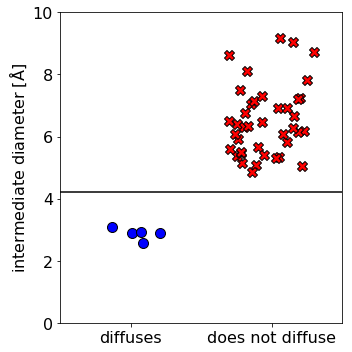

In [24]:
threshold = float(param_dict['diffuse_threshold'])
dx = 0.15
fig, ax = plt.subplots(figsize=(5,5))
for name, smile in molecules.items():
    out_file = output_dir+name.replace(' ', '_')+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    results = pd.read_csv(out_file)
    mid_diam = min(results['diam2'])
    if mid_diam <= threshold:
        C = 'b'
        M = 'o'
        E = 'k'
        D = 0.25
    else:
        C = 'r'
        M = 'X'
        E = 'k'
        D = 0.75
    ax.scatter(D+(dx*(np.random.random() - 0.5) * 2),
               mid_diam, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
ax.axhline(y=threshold, c='k')
define_plot_variables(ax,
                      title='',
                      xtitle='',
                      ytitle='intermediate diameter [$\mathrm{\AA}$]',
                      xlim=(0, 1),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"categorical.pdf", dpi=720,
            bbox_inches='tight')

#### Plot shapes

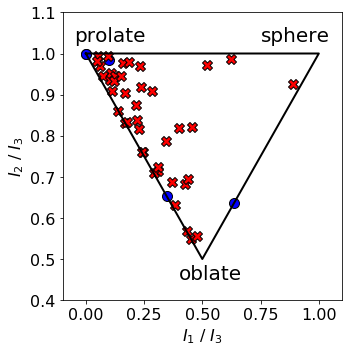

In [25]:
threshold = float(param_dict['diffuse_threshold'])
fig, ax = plt.subplots(figsize=(5,5))
for name, smile in molecules.items():
    out_file = output_dir+name.replace(' ', '_')+'_diam_result.csv'
    if os.path.isfile(out_file) is False:
        continue
    results = pd.read_csv(out_file)
    mid_diam = min(results['diam2'])
    if mid_diam <= threshold:
        C = 'b'
        M = 'o'
        E = 'k'
        D = 0.25
    else:
        C = 'r'
        M = 'X'
        E = 'k'
        D = 0.75
    ax.scatter(np.average(results['ratio_1']),
               np.average(results['ratio_2']),
               c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
ax.plot([0, 0.5, 1, 0], [1, 0.5, 1, 1], c='k', lw=2)
ax.text(0.75, 1.03, 'sphere', fontsize=20)
ax.text(0.4, 0.45, 'oblate', fontsize=20)
ax.text(-0.05, 1.03, 'prolate', fontsize=20)
define_parity_plot_variables(ax,
                             title='',
                             xtitle='$I_1$ / $I_3$',
                             ytitle='$I_2$ / $I_3$',
                             xlim=(-0.1, 1.1),
                             ylim=(0.4, 1.1))
fig.tight_layout()
fig.savefig(output_dir+"shape.pdf", dpi=720,
            bbox_inches='tight')

# Collect reactant-product systems 
suggest new reactions!

### Collect all reaction systems from multiple databases
Online.

In [3]:
# set output directory
output_dir = '/home/atarzia/psp/screening_results/biomin_search/'

# set databases to search to collect reaction systems
# BKMS should always be last as the culmination of all DBs
Databases = ['SABIO', 'KEGG', 'BKMS']

# set EC numbers of interest
EC_int = ['1.11.1.5', '1.11.1.6', '1.11.1.7', '1.9.3.1',
          '1.1.5.2', '3.5.1.5', '1.1.3.4', '1.13.12.4',
          '3.2.1.26', '3.1.1.3', '3.1.1.6', '3.5.1.11']

In [4]:
for DB in Databases:
    # get database specific information
    DB_prop = DB_functions.get_DB_prop(DB)
    db_dir = DB_prop[0]
    # iterate over EC numbers of interest
    for EC in EC_int:
        rxn_syst.get_reaction_systems(EC, DB, output_dir, clean_system=False)

39 matching entries found.
DB: SABIO - EC: 1.11.1.5 - DB ID: 23571 - 0 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23572 - 1 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23573 - 2 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23574 - 3 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23575 - 4 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23576 - 5 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23577 - 6 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23578 - 7 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23579 - 8 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23580 - 9 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23581 - 10 of 39
-----------------------------------
DB: SABIO - EC: 1.11.1.5 -

67 matching entries found.
DB: SABIO - EC: 1.11.1.7 - DB ID: 19982 - 0 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19983 - 1 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19984 - 2 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19985 - 3 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19986 - 4 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19987 - 5 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19988 - 6 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19989 - 7 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 19990 - 8 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2033 - 9 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2034 - 10 of 67
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - D

51 matching entries found.
DB: SABIO - EC: 1.1.3.4 - DB ID: 11576 - 0 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11577 - 1 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11578 - 2 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11579 - 3 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11580 - 4 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11581 - 5 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11582 - 6 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11583 - 7 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11584 - 8 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11585 - 9 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11586 - 10 of 51
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 1158

72 matching entries found.
DB: SABIO - EC: 3.1.1.3 - DB ID: 21245 - 0 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21246 - 1 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21247 - 2 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21248 - 3 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21249 - 4 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21250 - 5 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21251 - 6 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21252 - 7 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21253 - 8 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21254 - 9 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 22631 - 10 of 72
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 2263

DB: KEGG - EC: 1.13.12.4 - DB ID: R00319 - 0 of 1
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R00801 - 0 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R00802 - 1 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R02410 - 2 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R03635 - 3 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R03921 - 4 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R06088 - 5 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R06100 - 6 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R06101 - 7 of 9
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R06102 - 8 of 9
-----------------------------------
DB: KEGG - EC: 3.1.1.3 - DB ID: R01369 - 0 of 5
-----------------------------------
DB: KEGG - EC: 3.1.1.3 - DB ID: R02250 - 1 of 5
-----------------

### Check all reaction systems for if they fit through MOF
Not DB dependant.
Offline.

In [24]:
mol_output_file = output_dir+'screening_output.csv'
# get parameters
param_dict = parameters.get_parameters()
threshold = float(param_dict['diffuse_threshold'])

In [33]:
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)

In [34]:
# iterate over reaction system files
count = 0
for rs in yield_rxn_syst(output_dir):
    count += 1    
    if rs.skip_rxn is True:
        print('skipping reaction....')
        continue
    
    # define reactants and products dict
    # name: (smile, DB, DB_ID, iupac_name, role)
    components_dict = {}
    
    # ignore any reactions with unknown components
    rs.skip_rxn = False
    for m in rs.components:
        if m.mol is None:
            rs.skip_rxn = True
        if m.mid_diam == 0:
            rs.skip_rxn = True
    
    if rs.skip_rxn is True:
        print('skipping reaction - it is incomplete or generic')
        rs.save_object(output_dir+rs.pkl)
        continue
    for m in rs.components:
        # get IUPAC NAME
        m.iupac_name = None
        print("!! NEED TO GET IUPAC NAME !!")
        # remove reactions with general atoms (given by '*' in SMILES)
        if "*" in m.SMILES:
            rs.skip_rxn = True
            print('skipping reaction - it is incomplete or generic')
            rs.save_object(output_dir+rs.pkl)
            break
        components_dict[m.name] = (m.SMILES, m.DB, m.DB_ID, m.iupac_name, m.role.lower())
    
    # calculate molecule size of all components
    # save to molecule output files
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    DB_functions.get_molecule_diameters(components_dict,
                                        molecule_output=molecule_output,
                                        mol_output_file=mol_output_file, out_dir=output_dir,
                                        vdwScale=0.8, boxMargin=4.0, 
                                        spacing=0.6, N_conformers=50, MW_thresh=250)
    
    molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)
    
    # get diameters (should alrady be calculated) 
    # of all components of reaction
    rs.check_all_fit(threshold, molecule_output)
    rs.save_object(output_dir+rs.pkl)
    print('-----------------------------------')

DB: SABIO - EC: 1.11.1.6 - DB ID: 23680 - 0 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-23680.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 23680
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38326 - 1 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_5-SABIO-38326.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R06088 - 2 of 666
loading: /home/atarzia/psp/screening_results/biomin_sear

-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 48533 - 35 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-48533.pkl
skipping reaction - it is incomplete or generic
DB: SABIO - EC: 3.1.1.3 - DB ID: 52386 - 36 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-SABIO-52386.pkl
skipping reaction....
DB: BKMS - EC: 1.11.1.7 - DB ID: 16751 - 37 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_7-BKMS-16751.pkl
skipping reaction....
DB: SABIO - EC: 3.5.1.11 - DB ID: 18330 - 38 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_11-SABIO-18330.pkl
skipping reaction - it is incomplete or generic
DB: SABIO - EC: 3.5.1.11 - DB ID: 11616 - 39 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_11-SABIO-11616.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
------------

-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44708
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: BKMS - EC: 3.1.1.3 - DB ID: 21776 - 64 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-BKMS-21776.pkl
skipping reaction....
DB: SABIO - EC: 1.11.1.6 - DB ID: 44774 - 65 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44774.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44774
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
----

-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44734
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44740 - 96 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44740.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44740
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: KEGG - EC: 3.

-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44750
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44700 - 135 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44700.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44700
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: BKMS - EC: 1

-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44761
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 6384 - 167 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_7-SABIO-6384.pkl
skipping reaction....
DB: SABIO - EC: 3.1.1.3 - DB ID: 48406 - 168 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-SABIO-48406.pkl
skipping reaction....
DB: BKMS - EC: 1.11.1.5 - DB ID: 11028 - 169 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_5-BKMS-11028.pkl
skipping reaction....
DB: SABIO - EC: 3.1.1.3 - DB ID: 49723 - 170 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-SABIO-49723.pkl


-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 40237 - 208 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-40237.pkl
skipping reaction - it is incomplete or generic
DB: SABIO - EC: 1.11.1.6 - DB ID: 44785 - 209 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44785.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44785
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44754 - 210 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44754.pkl
!! NEED TO GET IUPAC NAME !!

-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44789 - 250 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44789.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44789
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11593 - 251 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_1_3_4-SABIO-11593.pkl
skipping reaction....
DB: KEGG - EC: 3.1.1.3 - DB ID: R02687 - 252 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-KEGG-R02687.pkl
skipping reaction....
DB: SABIO - EC: 1.11.1.5 - DB ID: 96

-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 37096 - 278 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-37096.pkl
skipping reaction - it is incomplete or generic
DB: KEGG - EC: 1.1.3.4 - DB ID: R01522 - 279 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_1_3_4-KEGG-R01522.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44718 - 280 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44718.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44718
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------

-----------------------------------
EC: 1.11.1.7
Database: BKMS
Database ID: 8220
-----------------------------------
hydrogen peroxide  (ID: 16240) as reactant
SMILES: OO
methanol  (ID: 17790) as reactant
SMILES: CO
formaldehyde  (ID: 16842) as product
SMILES: C=O
water  (ID: 15377) as product
SMILES: O
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: BKMS - EC: 3.1.1.3 - DB ID: 27972 - 314 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-BKMS-27972.pkl
skipping reaction....
DB: SABIO - EC: 1.11.1.7 - DB ID: 230 - 315 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_7-SABIO-230.pkl
skipping reaction....
DB: SABIO - EC: 3.5.1.11 - DB ID: 11610 - 316 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_11-SABIO-11610.pkl
skipping reaction - it is incomplete or generic
DB: SABIO - EC: 1.11.1.7 - DB ID: 227 - 31

-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 6098 - 342 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_1_3_4-SABIO-6098.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 49707 - 343 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-SABIO-49707.pkl
skipping reaction....
DB: SABIO - EC: 1.11.1.6 - DB ID: 6532 - 344 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-6532.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 6532
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will 

-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44790
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 231 - 373 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_7-SABIO-231.pkl
skipping reaction....
DB: SABIO - EC: 1.11.1.6 - DB ID: 44716 - 374 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44716.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44716
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
--

-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 59227 - 416 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-59227.pkl
skipping reaction - it is incomplete or generic
DB: SABIO - EC: 3.1.1.3 - DB ID: 49713 - 417 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-SABIO-49713.pkl
skipping reaction....
DB: SABIO - EC: 1.11.1.6 - DB ID: 44742 - 418 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44742.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44742
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: SABI

-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 25862 - 450 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-25862.pkl
skipping reaction - it is incomplete or generic
DB: SABIO - EC: 1.9.3.1 - DB ID: 53014 - 451 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_9_3_1-SABIO-53014.pkl
skipping reaction - it is incomplete or generic
DB: SABIO - EC: 3.5.1.5 - DB ID: 38314 - 452 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_5-SABIO-38314.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 35569 - 453 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_1_3_4-SABIO-35569.pkl
skipping reaction....
DB: SABIO - EC: 3.5.1.5 - DB ID: 42108 - 454 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_5-SABIO-42108.p

-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44771 - 484 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44771.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44771
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 48579 - 485 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-BKMS-48579.pkl
skipping reaction....
DB: SABIO - EC: 3.2.1.26 - DB ID: 37086 - 486 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-37086.pkl
skipping reaction - it is incomplete or generic
DB: SABI

-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R02410 - 519 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-KEGG-R02410.pkl
skipping reaction....
DB: BKMS - EC: 3.1.1.6 - DB ID: 7710 - 520 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_6-BKMS-7710.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 42270 - 521 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-42270.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 42270
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components wi

-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44776
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: KEGG - EC: 3.1.1.6 - DB ID: R00628 - 555 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_6-KEGG-R00628.pkl
skipping reaction....
DB: SABIO - EC: 3.1.1.3 - DB ID: 22634 - 556 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_3-SABIO-22634.pkl
skipping reaction - it is incomplete or generic
DB: SABIO - EC: 3.2.1.26 - DB ID: 39036 - 557 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-39036.pkl
skipping reaction - it is incomplete or generic
DB: KEGG - EC: 3.2.1.26 - DB ID: R03921 - 558 of 666
loading: /home/atarzia/psp/scree

-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 6539
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 18327 - 590 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_11-SABIO-18327.pkl
skipping reaction - it is incomplete or generic
DB: BKMS - EC: 3.1.1.6 - DB ID: 6084 - 591 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_1_1_6-BKMS-6084.pkl
skipping reaction....
DB: SABIO - EC: 3.5.1.11 - DB ID: 11615 - 592 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_11-SABIO-11615.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
--------------------

-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14945 - 624 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_5_1_11-SABIO-14945.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 3734 - 625 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_7-SABIO-3734.pkl
skipping reaction....
DB: SABIO - EC: 1.9.3.1 - DB ID: 53012 - 626 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_9_3_1-SABIO-53012.pkl
skipping reaction - it is incomplete or generic
DB: SABIO - EC: 1.11.1.6 - DB ID: 6535 - 627 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-6535.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 6535
--------------

-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44783 - 663 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-SABIO-44783.pkl
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
!! NEED TO GET IUPAC NAME !!
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44783
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 48544 - 664 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-3_2_1_26-SABIO-48544.pkl
skipping reaction - it is incomplete or generic
DB: KEGG - EC: 1.11.1.6 - DB ID: R00602 - 665 of 666
loading: /home/atarzia/psp/screening_results/biomin_search/sRS-1_11_1_6-KEGG-R00602.pkl
!! NEED TO GET IUPAC NAME !!

### Get subset of reaction systems that fit, with known protein sequences and checks if MOF can be seeded
DB dependant.
Online collection of Uniprot sequence.

In [35]:
param_dict = parameters.get_parameters()

In [36]:
react_syst_files = glob.glob(output_dir+'sRS-*.pkl')

In [37]:
# iterate over reaction system files
count = 0
for rs in yield_rxn_syst(output_dir):
    count += 1
    if rs.skip_rxn is True:
        print('skipping reaction....')
        print('-----------------------------------')
        continue
    # this is only possible for reaction systems with UNIPROT ID
    if rs.UniprotID is None or rs.UniprotID == '':
        print('no sequence known')
        print('-----------------------------------')
        continue
        
    # split UniprotID for the cases where multiple subunits exist
    IDs = rs.UniprotID.split(" ")
    print('Uniprot IDs:', IDs)
    # pI already checked?
    if rs.seed_MOF is not None:
        print('-----------------------------------')
        continue
    if len(IDs) > 0:
        # iterate over all UniProtIDs
        # assume all sequences require pI < cutoff for MOF growth
        # this is done by collating all sequences
        total_sequence = ''
        for i in IDs:
            sequence = Uniprot_IO.get_sequence(i)
            total_sequence += sequence
        rs = pi_fn.calculate_rxn_syst_pI(total_sequence, rs, param_dict=param_dict)
        rs.save_object(output_dir+rs.pkl)
        print('seed MOF?', rs.seed_MOF)
    else:
        rs.save_object(output_dir+rs.pkl)
        print('seed MOF?', rs.seed_MOF)
    print('-----------------------------------')

DB: SABIO - EC: 1.11.1.6 - DB ID: 23680 - 0 of 666
Uniprot IDs: ['Q939D2']
-----------------------------------
DB: SABIO - EC: 3.5.1.5 - DB ID: 38326 - 1 of 666
Uniprot IDs: ['P18314', 'P18315', 'P18316']
-----------------------------------
DB: KEGG - EC: 3.2.1.26 - DB ID: R06088 - 2 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 44391 - 3 of 666
skipping reaction....
-----------------------------------
DB: BKMS - EC: 3.2.1.26 - DB ID: 11374 - 4 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14949 - 5 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 42948 - 6 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.11.1.5 - DB ID: 23599 - 7 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.11.1.7 - DB ID: 2289 - 8 of 666
Uniprot IDs: ['Q6PQF2']
----------------------------------

Uniprot IDs: ['P73911']
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 52389 - 261 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 11605 - 262 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 3.1.1.6 - DB ID: 58618 - 263 of 666
Uniprot IDs: ['P00918']
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44763 - 264 of 666
no sequence known
-----------------------------------
DB: SABIO - EC: 3.2.1.26 - DB ID: 55894 - 265 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 11588 - 266 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44735 - 267 of 666
Uniprot IDs: ['P00432']
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44728 - 268 of 666
Uniprot IDs: ['P46206']
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 21252 - 269 of 666
s

skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.1.3.4 - DB ID: 32726 - 438 of 666
no sequence known
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 44389 - 439 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 42268 - 440 of 666
Uniprot IDs: ['P21179']
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44706 - 441 of 666
Uniprot IDs: ['P77872']
-----------------------------------
DB: BKMS - EC: 3.1.1.6 - DB ID: 7717 - 442 of 666
no sequence known
-----------------------------------
DB: BKMS - EC: 1.1.3.4 - DB ID: 6739 - 443 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 1.11.1.6 - DB ID: 44788 - 444 of 666
no sequence known
-----------------------------------
DB: SABIO - EC: 3.1.1.3 - DB ID: 49722 - 445 of 666
skipping reaction....
-----------------------------------
DB: SABIO - EC: 3.5.1.11 - DB ID: 14939 - 446 of 666
skipping reaction.

## Output

### percentage of reaction systems with sequence data?

In [91]:
count = 0

for rs in yield_rxn_syst(output_dir):
    # this is only possible for reaction systems with UNIPROT ID
    if rs.UniprotID != '':
        if rs.UniprotID != None:
            count += 1
        
print('-----------------------------------')
print(count, 'reaction systems of', len(react_syst_files), 'had a sequence.')
print('=>', round(count/len(react_syst_files), 4)*100, 'percent')
print('-----------------------------------')

-----------------------------------
449 reaction systems of 666 had a sequence.
=> 67.42 percent
-----------------------------------


### Plot distribution of all pI values for reaction systems

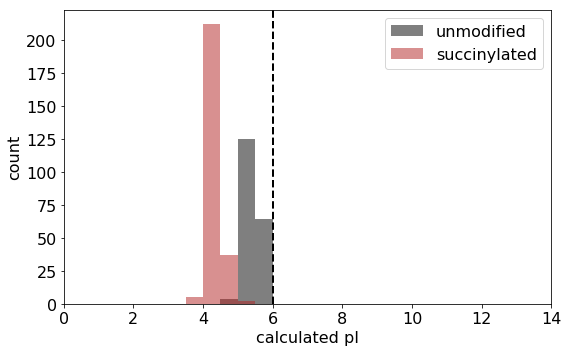

In [95]:
fig, ax = plt.subplots(figsize=(8,5))
native_pi = []
succ_pi = []
for rs in yield_rxn_syst(output_dir):    
    # collect pIs of all sequences even if reaction is skipped elsewhere
    if rs.skip_rxn is True and rs.UniprotID != '' and rs.UniprotID != None:
        try:
            pI = rs.pI
        except AttributeError:
            print('calculating pI')
            IDs = rs.UniprotID.split(" ")
            total_sequence = ''
            for i in IDs:
                sequence = Uniprot_IO.get_sequence(i)
                total_sequence += sequence
            rs = pi_fn.calculate_rxn_syst_pI(total_sequence, rs, param_dict=param_dict)
            rs.save_object(output_dir+rs.pkl)
    
    if rs.UniprotID != '' and rs.UniprotID != None:
        if rs.req_mod == None:
            native_pi.append(rs.pI)
        else:
            succ_pi.append(rs.pI)
        
ax.hist(native_pi,
        facecolor='k',
        alpha=0.5,
        histtype='stepfilled',
        bins=np.arange(0, 14 + 0.2, 0.5),
        label='unmodified')

ax.hist(succ_pi,
        facecolor='firebrick',
        alpha=0.5,
        histtype='stepfilled',
        bins=np.arange(0, 14 + 0.2, 0.5),
        label='succinylated')

ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel('calculated pI', fontsize=16)
ax.set_ylabel('count', fontsize=16)
ax.set_xlim(0, 14)
# plot pI cut-off
ax.axvline(x=param_dict['cutoff_pi'], c='k', lw='2', linestyle='--')
# legend
ax.legend(fontsize=16)

fig.tight_layout()
fig.savefig(output_dir+"pI_dist.pdf",
            dpi=720, bbox_inches='tight')

### Plot pI vs maximum component size

In [96]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


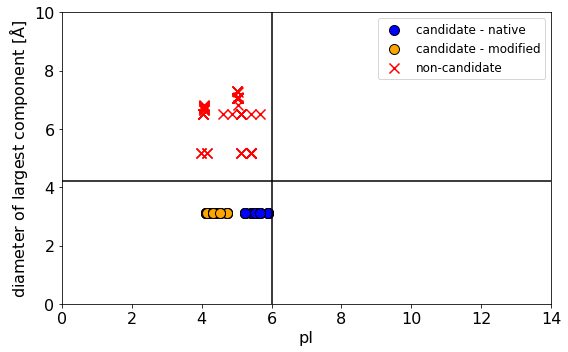

In [97]:
fig, ax = plt.subplots(figsize=(8,5))
# iterate over reaction system files
for rs in yield_rxn_syst(output_dir):
    if rs.skip_rxn is True:
        continue
        
    if rs.seed_MOF is None:
        continue
    
    if rs.all_fit is True and rs.seed_MOF is True:
        M = 'o'
        if rs.req_mod is not None:
            C = 'orange'
        else:
            C = 'b'
        E = 'k'
    else:
        #if rs.pI < 6 or rs.max_comp_size < 4.2:
        #    print(rs.seed_MOF, rs.all_fit, rs.pkl, rs.pI, rs.max_comp_size)
        #    input('done')
        M = 'x'
        C = 'r'
        E = 'k'
        
    ax.scatter(rs.pI,
               rs.max_comp_size, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
# decoy legend
ax.scatter(-100, 100,
           c='b', 
           edgecolors=E,
           marker='o', 
           alpha=1.0,
           s=100,
           label='candidate - native')
ax.scatter(-100, 100,
           c='orange',
           edgecolors=E,
           marker='o',
           alpha=1,
           s=100,
           label='candidate - modified')
ax.scatter(-100, 100,
           c='r',
           edgecolors=E,
           marker='x',
           alpha=1,
           s=100,
           label='non-candidate')

ax.legend(loc=1, fontsize=12)

ax.axhline(y=threshold, c='k')
ax.axvline(x=param_dict['cutoff_pi'], c='k')
define_plot_variables(ax,
                      title='',
                      xtitle='pI',
                      ytitle='diameter of largest component [$\mathrm{\AA}$]',
                      xlim=(0, 14),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"size_vs_pI.pdf", dpi=720,
            bbox_inches='tight')

### Plot # of reactions vs threshold value

In [44]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_xlabel(xtitle, fontsize=16)
    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)


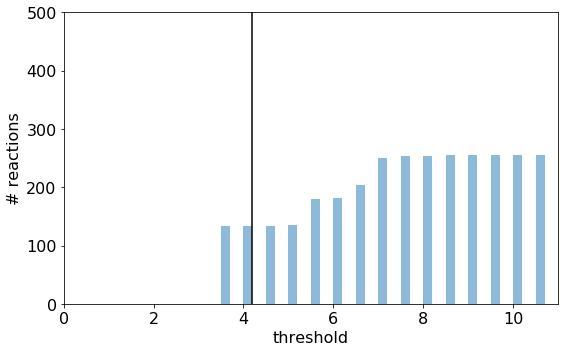

In [98]:
fig, ax = plt.subplots(figsize=(8,5))
max_sizes = []
# iterate over reaction system files
for rs in yield_rxn_syst(output_dir):
    if rs.skip_rxn is True:
        continue

    try:
        if rs.max_comp_size > 0:
            max_sizes.append(rs.max_comp_size)
    except AttributeError:
        pass
    
max_sizes = np.asarray(max_sizes)
counts = []
threshs = np.arange(0.1, 21, 0.5)
for thr in threshs:
    count_above = len(max_sizes[max_sizes < thr])
    counts.append(count_above)
    
ax.bar(threshs, counts, align='center', alpha=0.5, width=0.2)

ax.axvline(x=threshold, c='k')

define_plot_variables(ax,
                      title='',
                      xtitle='threshold',
                      ytitle='# reactions',
                      xlim=(0, 11),
                      ylim=(0, 500))
fig.tight_layout()
fig.savefig(output_dir+"size_vs_threshold.pdf", dpi=720,
            bbox_inches='tight')

### Categorize all molecules in output file

In [47]:
def define_plot_variables(ax, title, ytitle, xtitle, xlim, ylim):
    """
    Series of matplotlib pyplot settings to make all plots unitform.
    """
    # Set number of ticks for x-axis
    ax.tick_params(axis='both', which='major', labelsize=16)

    ax.set_ylabel(ytitle, fontsize=16)
    # ax.legend([y, n], ['aligned', 'not aligned'], loc=4, fancybox=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticklabels(['diffuses', 'does not diffuse'])
    ax.set_xticks([0.25, 0.75])

In [48]:
molecule_output = DB_functions.initialize_mol_output_DF(mol_output_file, overwrite=False)

unique molecule that fits: H2O - DB: SABIO - ID: 40
unique molecule that fits: H2O2 - DB: SABIO - ID: 1909
unique molecule that fits: O2 - DB: SABIO - ID: 1264
unique molecule that fits: NH3 - DB: SABIO - ID: 1268
unique molecule that fits: CO2 - DB: SABIO - ID: 1266
unique molecule that fits: methanol - DB: BKMS - ID: 17790
unique molecule that fits: formaldehyde - DB: BKMS - ID: 16842
unique molecule that fits: Ca2+ - DB: SABIO - ID: 1289
unique molecule that fits: CN- - DB: SABIO - ID: 2269
unique molecule that fits: dioxygen - DB: BKMS - ID: 15379
unique molecule that fits: superoxide - DB: BKMS - ID: 18421
unique molecule that fits: hydron - DB: BKMS - ID: 15378
unique molecule that fits: bromide - DB: BKMS - ID: 15858
unique molecule that fits: hypobromous acid - DB: BKMS - ID: 29249


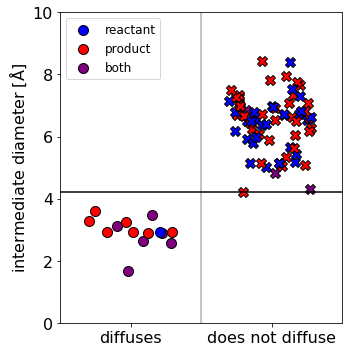

In [49]:
dx = 0.15
fig, ax = plt.subplots(figsize=(5,5))
for idx, row in molecule_output.iterrows():
    mid_diam = row['mid_diam']
    if mid_diam == 0:
        continue
    if mid_diam <= threshold:
        M = 'o'
        E = 'k'
        D = 0.25
        print('unique molecule that fits:', row['name'], 
              '- DB:', row['DB'], '- ID:', row['DB_ID'])
    else:
        M = 'X'
        E = 'k'
        D = 0.75
    
    # set colour based on role
    if row['role'] == 'reactant':
        C = 'b'
    elif row['role'] == 'product':
        C = 'r'
    elif row['role'] == 'both':
        C = 'purple'
    
    ax.scatter(D+(dx*(np.random.random() - 0.5) * 2),
               mid_diam, c=C, 
               edgecolors=E, marker=M, alpha=1.0,
               s=100)
    
# decoy legend
ax.scatter(-100, 100,
           c='b', 
           edgecolors=E, marker='o', alpha=1.0,
           s=100,
           label='reactant')
ax.scatter(-100, 100,
           c='r', 
           edgecolors=E, marker='o', alpha=1.0,
           s=100,
           label='product')
ax.scatter(-100, 100,
           c='purple', 
           edgecolors=E, marker='o', alpha=1.0,
           s=100,
           label='both')

ax.legend(loc=2, fontsize=12)

ax.axhline(y=threshold, c='k')
ax.axvline(x=0.5, c='k', alpha=0.3)
define_plot_variables(ax,
                      title='',
                      xtitle='',
                      ytitle='intermediate diameter [$\mathrm{\AA}$]',
                      xlim=(0, 1),
                      ylim=(0, 10))
fig.tight_layout()
fig.savefig(output_dir+"categorical.pdf", dpi=720,
            bbox_inches='tight')

In [156]:
molecule_output

,name,iupac_name,DB,DB_ID,SMILE,role,min_diam,mid_diam,max_diam,ratio_1,ratio_2
0,Ferrocytochrome c,NaN,SABIO,1938,CN=C(O)C(N)CSC(C)c1c(C)c2cc3[nH]c(cc4[nH]c(cc5...,both,0.000,0.000,0.000,0.000,0.000
1,H2O,NaN,SABIO,40,O,both,2.492,2.586,3.748,0.347,0.653
2,H2O2,NaN,SABIO,1909,OO,both,2.903,3.112,4.132,0.101,0.984
3,O2,NaN,SABIO,1264,[O],both,2.635,2.639,2.675,0.000,0.000
4,NH3,NaN,SABIO,1268,N,product,2.683,2.928,3.507,0.636,0.636
5,Urea,NaN,SABIO,1798,N=C(N)O,reactant,2.867,5.181,5.775,0.446,0.554
6,CO2,NaN,SABIO,1266,O=C=O,product,2.806,2.916,5.312,0.000,1.000
7,sucrose,NaN,KEGG,17992,OCC1OC(OC2(CO)OC(CO)C(O)C2O)C(O)C(O)C1O,reactant,0.000,0.000,0.000,0.000,0.000
8,beta-D-fructofuranose,NaN,KEGG,28645,O[CH2:1][C@@:2]1(O)O[C@H:5]([CH2:6]O)[C@@H:4](...,product,5.496,7.048,9.141,0.390,0.791
9,alpha-D-glucose,NaN,KEGG,17925,O[C@H:1]1O[C@H:5]([CH2:6]O)[C@@H:4](O)[C@H:3](...,product,4.942,7.281,8.423,0.408,0.699


### print all reactions that fit

In [99]:
count = 0
# iterate over reaction system files
for rs in yield_rxn_syst(output_dir):
    if rs.skip_rxn is True:
        continue
    if rs.all_fit is True:
        count += 1
        print("New Reaction:")
        rs.print_rxn_system()
        
print("There are", count, "new reactions!")

New Reaction:
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 23680
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
New Reaction:
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 42262
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
New Reaction:
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44753
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All c

New Reaction:
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44773
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
New Reaction:
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44731
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All components will diffuse through!
-----------------------------------
New Reaction:
-----------------------------------
EC: 1.11.1.6
Database: SABIO
Database ID: 44790
-----------------------------------
H2O  (ID: 40) as product
SMILES: O
O2  (ID: 1264) as product
SMILES: [O]
H2O2  (ID: 1909) as reactant
SMILES: OO
-----------------------------------
All c

New Reaction:
-----------------------------------
EC: 1.11.1.6
Database: KEGG
Database ID: R00602
-----------------------------------
methanol  (ID: 17790) as reactant
SMILES: CO
hydrogen peroxide  (ID: 16240) as reactant
SMILES: OO
formaldehyde  (ID: 16842) as product
SMILES: C=O
water  (ID: 15377) as product
SMILES: O
-----------------------------------
All components will diffuse through!
-----------------------------------
There are 133 new reactions!


# Archive Code

## Brenda Attempts

In [12]:
from IPython.display import clear_output

In [15]:
print('Screen all Enzymes in EC Classes using BRENDA data')
count_done = 0
total_start_time = time.time()
for EC_file in database_names:
    if EC_file != '/home/atarzia/psp/sequence_db/bio_min_dataset/1_11_1_7__BRENDA_sequences.fasta':
        continue
    # read the file
    # but to avoid memory issues
    # we will calculate the pI on the fly
    # using the bio python module
    print('-----------------------------------------------')
    print('doing:', EC_file)
    file_mod = EC_file.replace(".fasta", "_mod.fasta")
    EC_pi_data = pi_data[pi_data['fasta_file'] == file_mod]
    # only keep those that pass the pI test
    pi_passed_data = EC_pi_data[EC_pi_data['pi'] < param_dict['cutoff_pi']]
    print('--- ', 
          len(pi_passed_data), 'proteins out of', len(EC_pi_data), 
          'remain, OR', int(len(pi_passed_data)/len(EC_pi_data)*100),
          "% ---")
    EC_no = list(set(EC_pi_data['EC.code']))[0].replace(' ', '').replace(".", "_")
    print('EC:', EC_no.replace("_", "."))
    br_datafile = 'brenda_download_'+EC_no+'.txt'
    # convert br_datafile into dictionary
    br_symbols, br_data = brenda_IO.get_brenda_dict(param_dict['BRENDA_DB_loc']+br_datafile)
    # from here is quite bio-min assay literature specific
    # - although the code can be reused
    # get species of interest from known EC records
    ## when generalizing - we want to remove this for loop
    species_of_interest = EC_set[EC_no.replace('_', '.')]
    for spec in species_of_interest:
        print('species:', spec)
        spec_in_seq, spec_in_br = brenda_IO.is_species_reported(spec, 
                                                                EC_pi_data, 
                                                                br_data, 
                                                                verbose=True)
        # get protein numbers associated with species
        PR_of_int = []
        for i in sorted(br_data['PR']):
            if spec in i.lower():
                # this assumes that the first item of each line is always "#"
                PR_info = i.split("#")[1]            
                if PR_info not in PR_of_int:
                    PR_of_int.append(PR_info)
        print('when you want to go species unspecific you set PR_of_int to None and loop over all.')
        # get reaction systems from BRENDA
        prop_of_int = 'SP'
        list_of_int = br_data[prop_of_int]
        EC_prop_PR_codes = brenda_IO.get_prop_PR_codes(list_of_int)
        value_of_int = {}
        ## when generalizing - we want to remove this for loop
        for PR in PR_of_int:
            if PR in set([j for i in EC_prop_PR_codes.values() for j in i ]):
                print('protein code:', PR, 'has', prop_of_int, 'in BRENDA')
            else:
                print('protein code:', PR, 'does not have', prop, 'in BRENDA')
            values = [list_of_int[i]
                      for i in EC_prop_PR_codes.keys() if PR in EC_prop_PR_codes[i]]
            count = 0
            # iterate over all lines of BRENDA file with PR in SP initial
            for val in values:
                #if '3-(4-hydroxyphenyl)propanoic' not in val:
                #    continue
                print(val)
                print('############################')
                # split val into sections and remove preceding sections to avoid
                # confusion
                PR_sect = val.split("# ")[0]+"# "
                val = val.replace(PR_sect, '')
                rxn_sect = val.split(" (")[0].split(" <")[0]
                val = val.replace(rxn_sect, '')
                meta_sect = val
                # output dictionary
                reaction_system = brenda_IO.Reaction_system(EC_no, prop_of_int, PR, str(count))
                # get all PR associated with rxn system
                # strip value of anything in the first pair of "#" >> as PR codes
                t_assoc_PR = PR_sect.split("#")[1].split(',')
                # check for new lines and split string into list
                reaction_system.assoc_PR = brenda_IO.check_new_lines_and_split(t_assoc_PR)
                # strip value of anything in "(" and ")" >> as meta
                reaction_system.meta = meta_sect
                # split meta info into:
                # references 
                # references for an entry in BRENDA are within "<" and ">"
                t_assoc_refs = val.split(" <")[-1]
                t_assoc_refs = t_assoc_refs.split(">")[0].split(',')
                reaction_system.assoc_refs = brenda_IO.check_new_lines_and_split(t_assoc_refs)
                # reversible?
                # for the "SP" entries - a 'r' enclosed in "{" and "}"
                # implies reversible
                if '{r}' in reaction_system.meta:
                    reaction_system.reversible = True
                # reaction catalysed and reaction type
                reaction_system.extract_general_rxn_info(br_data)

                # make into function -- extract_reactants_products
                # get reactants as before '=' and products as after
                react, prod = rxn_sect.split("=")
                # separate react and prod into molecules by "+"
                r_mol = react.split("+")
                p_mol = prod.split("+")
                # remove preceding and succeeding white space from all molecule names
                r_mol = [i.lstrip().rstrip() for i in r_mol]
                p_mol = [i.lstrip().rstrip() for i in p_mol]
                #####

                # add flags to reaction system for informaton also available in BRENDA
                # no. subunits
                reaction_system.extract_subunit_info(br_data, PR)
                # post translational mods
                reaction_system.extract_PTM(br_data, PR)
                # cofactors
                reaction_system.extract_cofactor_info(br_data, PR)
                # activation cmpds?
                reaction_system.extract_activating_mol(br_data, PR)

                reaction_system.react_mol = r_mol
                reaction_system.prod_mol = p_mol
                
                reaction_system.print_rxn_system()
                input('done?')
                clear_output()
                # output reacion system to file
                # prefix + EC + property + PR code in BRENDA + count of associated files .pkl
                pickle_name = reaction_system.pickle_name
                # pickle reaction system object
                reaction_system.save_object(output_dir+pickle_name)
                count += 1

            break
            if len(values) > 0:
                value_of_int[PR] = values
    count_done += 1
print('--- finished %s EC classes in %s seconds ---' % (count_done, '{0:.2f}'.format(time.time() - total_start_time)))

#12,52# esculetin + H2O2 = ? (#52# demonstration, that esculetin is no
inhibitor, but a substrate of mushroom polyphenol oxidase (PPO) and
horseradish peroxidase (POD) <83>) <28,83>

############################
--------------------------
Reaction system in: RS-1_11_1_7-SP_52_2.pkl
Reaction Catalysed:
['2 phenolic donor + H2O2 = 2 phenoxyl radical of the donor + 2 H2O']
Reaction Type:
['redox reaction', 'oxidation', 'reduction', 'hydroxylation']
--------------------------
Reactants: esculetin + H2O2 -------->
Products: ?
Activating Molecules: melamine OR 2-aminothiazole
--------------------------
No. Sub units = ['?', 'monomer']
Reversible?: None
Co factors?: True
Cofactor Molecules: heme
Post Translational Mods?: ['glycoprotein']
--------------------------
Meta (in full):
 (#52# demonstration, that esculetin is no
inhibitor, but a substrate of mushroom polyphenol oxidase (PPO) and
horseradish peroxidase (POD) <83>) <28,83>

References: ['28', '83']
--------------------------


KeyboardInterrupt: 

In [9]:
file_t = '/home/atarzia/psp/sequence_db/bio_min_dataset/3_1_1_6__BRENDA_sequences_mod.fasta'
temp1 = pi_data[pi_data['fasta_file'] == file_t]
temp2 = temp1[temp1['species'] == ' Vibrio parahaemolyticus V-223/04 ']
print(temp2)

                                                fasta_file acc.code  \
1305091  /home/atarzia/psp/sequence_db/bio_min_dataset/...  Z2DBW5    
1305092  /home/atarzia/psp/sequence_db/bio_min_dataset/...  Z2DBW5    
1305123  /home/atarzia/psp/sequence_db/bio_min_dataset/...  Z2EP46    

                 organism    EC.code                             species  \
1305091   acetylesterase    3.1.1.6    Vibrio parahaemolyticus V-223/04    
1305092   acetylesterase    3.1.1.6    Vibrio parahaemolyticus V-223/04    
1305123   acetylesterase    3.1.1.6    Vibrio parahaemolyticus V-223/04    

            note    pi  modification  category  
1305091   TrEMBL  6.38             0         1  
1305092   TrEMBL  6.38             1         1  
1305123   TrEMBL  5.79             0         0  


In [10]:
temp1.loc[1305123]['species']

' Vibrio parahaemolyticus V-223/04 '

##  load in reaction system

In [38]:
# load in reaction system from pickle file
new_reaction_system = brenda_IO.Reaction_system.load_object(output_dir+pickle_name)

In [39]:
new_reaction_system.print_rxn_system()

--------------------------
Reaction system in: RS-1_11_1_7-SP_52_0.pkl
Reaction Catalysed:
['2 phenolic donor + H2O2 = 2 phenoxyl radical of the donor + 2 H2O']
Reaction Type:
['redox reaction', 'oxidation', 'reduction', 'hydroxylation']
--------------------------
Reactants: guaiacol + H2O2 -------->
Products: tetraguaiacol + H2O
Activating Molecules: melamine OR 2-aminothiazole
--------------------------
No. Sub units = ['?', 'monomer']
Reversible?: None
Co factors?: True
Cofactor Molecules: heme
Post Translational Mods?: ['glycoprotein']
--------------------------
Meta (in full):
(#64# 100% activity <80>; #83# 100% activity with guaiacol at 25 mM
<105>; #44# 74% activity compared to
2,2-azino-bis-(3-ethyl-6-benzothiazolinsulfonate) <82>; #82# shows high
efficiency of interaction with guaiacol at 25 mM <105>; #30# 100%
activity, high efficiency of interaction with guaiacol at 25 mM <105>;
#52# optimal concentrations of guaiacol and H2O2 are 0.5 mM and 0.3 mM,
respectively <139>)
<5,6,

## collect SMILES from common name from Brenda

### CHEMBL

In [43]:
available_resources = [resource for resource in dir(new_client) if not resource.startswith('_')]
print(available_resources)
print(len(available_resources))

# molecule handler
molecule = new_client.molecule
molecule.set_format('json')

# get molecule using unambiguous
m3 = molecule.get('CC(=O)Oc1ccccc1C(=O)O')

# batch queries
records3 = molecule.get(['CNC(=O)c1ccc(cc1)N(CC#C)Cc2ccc3nc(C)nc(O)c3c2',
            'Cc1cc2SC(C)(C)CC(C)(C)c2cc1\\N=C(/S)\\Nc3ccc(cc3)S(=O)(=O)N',
            'CC(C)C[C@H](NC(=O)[C@@H](NC(=O)[C@H](Cc1c[nH]c2ccccc12)NC(=O)[C@H]3CCCN3C(=O)C(CCCCN)CCCCN)C(C)(C)C)C(=O)O'])

['activity', 'assay', 'atc_class', 'binding_site', 'biotherapeutic', 'cell_line', 'chembl_id_lookup', 'compound_record', 'compound_structural_alert', 'description', 'document', 'document_similarity', 'document_term', 'drug', 'drug_indication', 'go_slim', 'image', 'mechanism', 'metabolism', 'molecule', 'molecule_form', 'official', 'organism', 'protein_class', 'similarity', 'source', 'substructure', 'target', 'target_component', 'target_prediction', 'target_relation', 'tissue', 'xref_source']
33


In [44]:
from chembl_webresource_client.new_client import new_client
molecule = new_client.molecule
res = molecule.search('vinylacetyl-CoA')  # 'viagra')
# guaiacol

In [45]:
print(res[0]['molecule_chembl_id'])
print(res[0]['molecule_structures']['canonical_smiles'])
print('there are', len(res), 'top search candidates:')
for i in range(len(res)):
    print('option:', i, 'name:', res[i]['pref_name'])
    print([res[i]['molecule_synonyms'][j]['synonyms'] for j in range(len(res[i]['molecule_synonyms']))])

TypeError: 'NoneType' object is not subscriptable